<a href="https://colab.research.google.com/github/Ersel26/echo_KVAK/blob/main/echo_KVAK_efficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2
import random
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras.optimizers import Adam
from keras.applications import EfficientNetB3
from keras.applications import EfficientNetB0
from keras.models import Sequential

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
DIRECTORY = r"/content/drive/MyDrive/Echo_KVAK/labeled data"
IMG_SIZE = 299 # for InceptionV3
BATCH_SIZE = 32
NUM_CLASSES = len(os.listdir(DIRECTORY))

In [4]:
def create_data_ImageDataGenerator(data_gen, data_dir):
  train_generator = data_gen.flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    subset='training'
  ) 
  validation_generator = data_gen.flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    subset='validation')  # set as validation data
  return (train_generator, validation_generator)

In [5]:
data_gen = ImageDataGenerator(
        # rotation_range=40,
        # width_shift_range=0.2,
        # height_shift_range=0.2,
        rotation_range=0,
        width_shift_range=0,
        height_shift_range=0,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        vertical_flip=True,
        fill_mode='nearest',
        validation_split=0.2)

(train_generator, validation_generator) = create_data_ImageDataGenerator(data_gen, DIRECTORY)

Found 9213 images belonging to 7 classes.
Found 2302 images belonging to 7 classes.


#label_dist function has written to calculate distribution of data set and use the values to determine class weights. class weights are hard coded with obtained numbers below. there is no need to run again.

In [ ]:
def label_dist(generator):
  first = 0
  second = 0
  third = 0
  fourth = 0
  fifth = 0
  sixth = 0
  seventh = 0
  total = 0

  for i, batch in enumerate(generator):
      images, labels = batch
      
      for label in labels:
        if (label[0] == 1.0):
          first += 1
        elif (label[1] == 1.0):
          second += 1
        elif (label[2] == 1.0):
          third += 1
        elif (label[3] == 1.0):
          fourth += 1
        elif (label[4] == 1.0):
          fifth += 1
        elif (label[5] == 1.0):
          sixth += 1
        elif (label[6] == 1.0):
          seventh += 1
        total += 1

      if i == 10:
        break

  print("{0:.2f}, {1:.2f}, {2:.2f}, {3:.2f}, {4:.2f}, {5:.2f}, {6:.2f}".format(first/total, second/total, third/total, fourth/total, fifth/total, sixth/total, seventh/total))

  return (first, second, third, fourth, fifth, sixth, seventh, total)

(first, second, third, fourth, fifth, sixth, seventh, total) = label_dist(train_generator)
# label_dist(validation_generator)

0.15, 0.03, 0.30, 0.06, 0.08, 0.24, 0.14


In [6]:
class_weights = {
    0: 2816 / (7 * 424) ,
    1: 2816 / (7 * 87),
    2: 2816 / (7 * 833),
    3: 2816 / (7 * 179),
    4: 2816 / (7 * 235),
    5: 2816 / (7 * 676),
    6: 2816 / (7 * 382)
}

# InceptionV3 w/o initial weights and w/o augmentation

In [7]:
inception = tf.keras.applications.inception_v3.InceptionV3(
    include_top=False,
    input_shape=(IMG_SIZE,IMG_SIZE,3),
    weights=None,
    input_tensor=None,
    pooling='max',
)

model = tf.keras.models.Sequential()
model.add(inception)
model.add(layers.Dense(units = NUM_CLASSES, activation='softmax'))
model.summary()

optimizer = keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,)

model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"] )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dense (Dense)               (None, 7)                 14343     
                                                                 
Total params: 21,817,127
Trainable params: 21,782,695
Non-trainable params: 34,432
_________________________________________________________________


In [8]:
history = model.fit(
    train_generator, 
    epochs = 30,
    validation_data = validation_generator, 
    verbose = 1,
    steps_per_epoch = 288,
    validation_steps = 8,
    class_weight = class_weights
    )

Epoch 1/30
288/288 [==============================] - 5727s 20s/step - loss: 2.1825 - accuracy: 0.2953 - val_loss: 2.3742 - val_accuracy: 0.0742
Epoch 2/30
288/288 [==============================] - 366s 1s/step - loss: 1.7943 - accuracy: 0.4092 - val_loss: 996.8377 - val_accuracy: 0.2383
Epoch 3/30
288/288 [==============================] - 335s 1s/step - loss: 1.7580 - accuracy: 0.4392 - val_loss: 223.8958 - val_accuracy: 0.3125
Epoch 4/30
288/288 [==============================] - 314s 1s/step - loss: 1.5259 - accuracy: 0.5221 - val_loss: 1.4484 - val_accuracy: 0.4766
Epoch 5/30
288/288 [==============================] - 324s 1s/step - loss: 1.6626 - accuracy: 0.4932 - val_loss: 22.8742 - val_accuracy: 0.2930
Epoch 6/30
288/288 [==============================] - 283s 984ms/step - loss: 1.4023 - accuracy: 0.5575 - val_loss: 1.3723 - val_accuracy: 0.5391
Epoch 7/30
288/288 [==============================] - 277s 962ms/step - loss: 1.1767 - accuracy: 0.6162 - val_loss: 0.9726 - val_acc

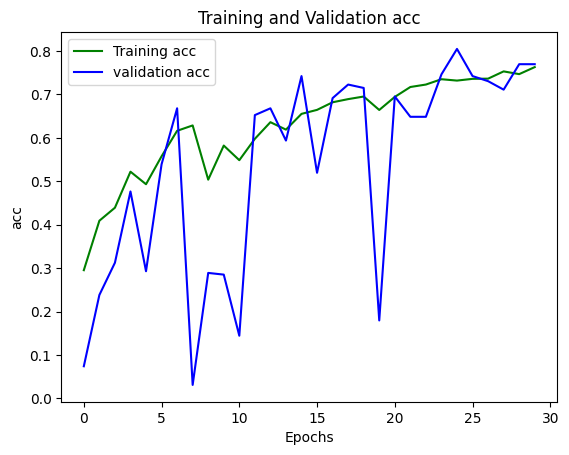

In [9]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(0,30)
plt.plot(epochs, loss_train, 'g', label='Training acc')
plt.plot(epochs, loss_val, 'b', label='validation acc')
plt.title('Training and Validation acc')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.legend()
plt.show()